In [60]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [174]:
data = pd.read_csv('../../assets/train.csv', sep='\t', na_values='?')

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

In [175]:
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-advantages-races,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races"",""body"":""And that can be carried on a pla...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Health-_-FightFluWithFruit,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body"":""Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent hea...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...
3,http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html,6684,"{""title"":""10 Foolproof Tips for Better Sleep "",""body"":""There was a period in my life when I had a lot of problems with sleep It took me very long to fall asleep I was easily awaken and I simply wasn t getting enough of rest at night I didn t want to take medication and this led me to learn sever...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1.0,0,24,0.

#### Build a feature matrix where X contains useful features and y contains the target variable `label`

In [176]:
# TODO
from sklearn import preprocessing


data = data[[x for x in data.columns if x not in ['title', 'body', 'alchemy_category', 
                                                                 'boilerplate', 'urlid', 'url']]]
data.dropna(inplace=True)
data.head()

,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0
1,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1
2,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1
3,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1.0,0,24,0.0,2737,120,5,0.041667,0.100858,1
4,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1.0,1,14,0.0,12032,162,10,0.098765,0.082569,0


In [177]:
data_ = preprocessing.normalize(data)
data_ = pd.DataFrame(data_)

data_['metric_pct'] = data_[[i for i in data_ if i not in ['label']]].sum(axis=1)/23


In [178]:
data_.dropna(axis=1, inplace=True)
data_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,metric_pct
0,0.000145,0.000379,0.000125,0.000038,0.000009,0.000004,0.000082,0.000000e+00,0.0,1.672719e-05,0.000000,0.000045,7.156243e-07,0.000184,0.000184,0.004423,0.000000,0.999498,0.031326,0.001474,2.818297e-05,0.000015,0.000000,0.045129
1,0.000115,0.000739,0.000102,0.000058,0.000043,0.000029,0.000094,0.000000e+00,0.0,1.983397e-05,0.000000,0.000041,1.781356e-05,0.000201,0.000201,0.008037,0.000000,0.999259,0.037575,0.001808,3.653399e-05,0.000025,0.000201,0.045591
2,0.000442,0.001056,0.000249,0.000143,0.000053,0.000019,0.000233,0.000000e+00,0.0,3.212040e-05,0.000000,0.000100,5.344058e-05,0.000443,0.000443,0.024385,0.000000,0.993124,0.114387,0.004877,7.389315e-05,0.000026,0.000443,0.049591
3,0.000292,0.000563,0.000146,0.000036,0.000006,0.000000,0.000175,0.000000e+00,0.0,3.498893e-05,0.000000,0.000097,1.290014e-05,0.000365,0.000000,0.008760,0.000000,0.999000,0.043800,0.001825,1.520826e-05,0.000037,0.000365,0.045893
4,0.000060,0.000222,0.000042,0.000018,0.000010,0.000004,0.000037,0.000000e+00,0.0,2.069992e-06,0.000000,0.000019,4.194528e-06,0.000083,0.000083,0.001163,0.000000,0.999908,0.013463,0.000831,8.207811e-06,0.000007,0.000000,0.044172
5,0.000171,0.000600,0.000167,0.000042,0.000033,0.000033,0.000449,0.000000e+00,0.0,3.066050e-05,0.000000,0.000170,2.412783e-04,0.000775,0.000000,0.016272,0.000000,0.997264,0.072063,0.002325,4.249312e-04,0.000050,0.000775,0.047473
6,0.000185,0.000567,0.000144,0.000066,0.000021,0.000011,0.000134,0.000000e+00,0.0,1.278580e-05,0.000000,0.000050,1.157261e-04,0.000226,0.000226,0.011994,0.000000,0.995985,0.088713,0.000000,3.637105e-05,0.000017,0.000000,0.047761
7,0.000813,0.002850,0.000555,0.000213,0.000041,0.000014,0.000534,0.000000e+00,0.0,6.952668e-05,0.000000,0.000220,7.841688e-05,0.000932,0.000932,0.059667,0.000000,0.990092,0.126791,0.008391,1.576666e-04,0.000168,0.000932,0.051889
8,0.002146,0.003336,0.000247,0.000000,0.000000,0.000000,0.001716,0.000000e+00,0.0,5.653192e-04,0.000000,0.001112,9.913113e-04,0.003588,0.000000,0.179380,0.000000,0.961478,0.208081,0.007175,4.948418e-04,0.000384,0.000000,0.059595
9,0.000900,0.002426,0.000490,0.000208,0.000049,0.000000,0.000539,0.000000e+00,0.0,1.161941e-04,0.000000,0.000270,3.212479e-04,0.001165,0.000000,0.057062,0.000000,0.992174,0.110630,0.009316,3.554861e-04,0.000163,0.000000,0.051138


In [179]:
metrics_pct = np.array(data_.metric_pct.values)
metrics_pct = metrics_pct[:, np.newaxis]
sss = StratifiedShuffleSplit(data[['label']].values, 1, test_size=0.33, random_state=77)
data_['label'] = data['label']
for train_index, test_index in sss:
    X_train, X_test = metrics_pct[train_index], metrics_pct[test_index]
    Y_train, Y_test = data['label'].values[train_index], data['label'].values[test_index]


#### Build a Logistic Regression model using scikit-learn
- Examine the coefficients using the `examine_coefficients` function provided
- Evaluate the AUC, precision and recall of the model using cross-validation (hint:use scoring parameter in cross_val_score
- Plot the ROC curve
- Iterate on the model by adding in additional features in `X` above

In [180]:
def examine_coefficients(model, df):
    return pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')

In [181]:
from sklearn.linear_model import LogisticRegression
# TODO
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
print Y_pred

[1 1 1 ..., 1 1 1]


In [182]:
## Probability vector
Y_pp = pd.DataFrame(logreg.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])


In [183]:
Y_pp['pred_class_thresh50'] = Y_pred
print(Y_pp.iloc[0:10])

   class_0_pp  class_1_pp  pred_class_thresh50
0    0.481238    0.518762                    1
1    0.481263    0.518737                    1
2    0.481308    0.518692                    1
3    0.481187    0.518813                    1
4    0.481734    0.518266                    1
5    0.482084    0.517916                    1
6    0.489179    0.510821                    1
7    0.481850    0.518150                    1
8    0.481710    0.518290                    1
9    0.481570    0.518430                    1


In [184]:
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_green', 'is_not_green'],
                         columns=['predicted_green','predicted_not_green'])

print(confusion)

              predicted_green  predicted_not_green
is_green                  609                    0
is_not_green              568                    0


In [185]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logreg.decision_function(X_test)
Y_proba_score = logreg.predict_proba(X_test)


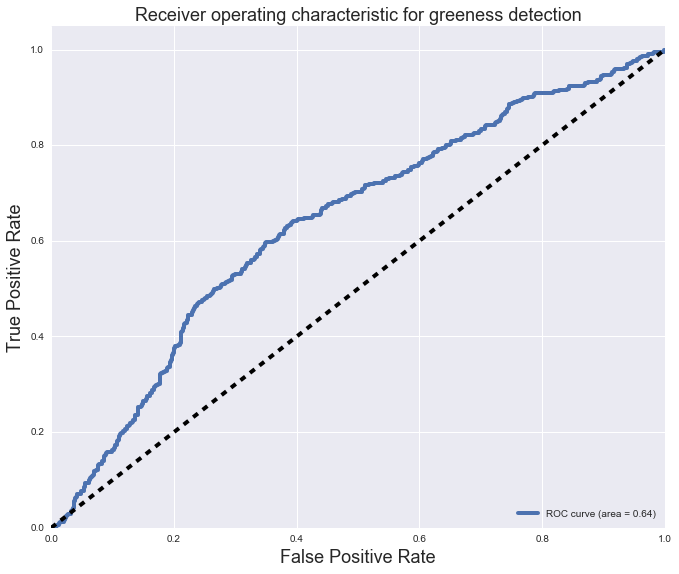

In [186]:
# For class 1, find the area under the curve
FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])
#can also do this:FPR, TPR, thresholds = roc_curve(Y_test, Y_score)

ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for greeness detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [201]:
df0 = np.array(data_[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]])
print df0


sss = StratifiedShuffleSplit(data[['label']].values, 1, test_size=0.33, random_state=77)

for train_index, test_index in sss:
    X_train, X_test = df0[train_index], df0[test_index]
    Y_train, Y_test = data['label'].values[train_index], data['label'].values[test_index]


logreg = LogisticRegression()

logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

Y_score = logreg.decision_function(X_test)
Y_proba_score = logreg.predict_proba(X_test)

[[  1.45415748e-04   3.78783940e-04   1.24655446e-04 ...,   2.81829703e-05
    1.45814654e-05   0.00000000e+00]
 [  1.15367351e-04   7.39039316e-04   1.02080272e-04 ...,   3.65339922e-05
    2.52071452e-05   2.00936957e-04]
 [  4.41818692e-04   1.05647238e-03   2.49174587e-04 ...,   7.38931536e-05
    2.55433124e-05   4.43358921e-04]
 ..., 
 [  2.93067177e-04   1.35513926e-03   2.13699823e-04 ...,   1.81872188e-05
    3.21524047e-05   0.00000000e+00]
 [  2.49857747e-05   3.88739656e-04   8.50934171e-05 ...,   3.52110692e-06
    1.92697393e-05   0.00000000e+00]
 [  1.58348212e-03   2.63022468e-03   5.39533268e-04 ...,   6.74416572e-05
    8.54261005e-04   2.56278302e-03]]


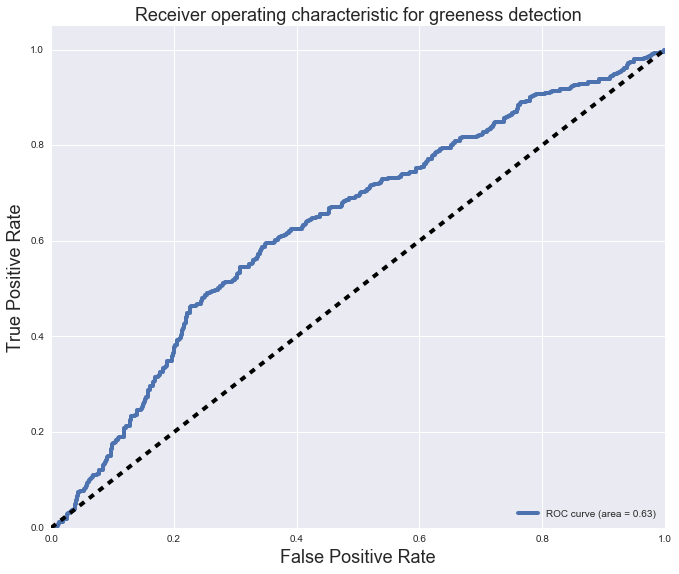

In [202]:
FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])
#can also do this:FPR, TPR, thresholds = roc_curve(Y_test, Y_score)

ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for greeness detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
## The model performed slightly worse with all variables as opposed to just the created one.